In [1]:
%load_ext autoreload
%autoreload 2

### Triplet Loss

We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.


<img src="./images/triplet.png" height="422" width="722" >

Triplet loss is given by the following :-

$$ \mathcal{L}(I_{1}, I_{2}, I_{3}) = ReLU\{m + (\mathcal{E}_{I_{1}} - \mathcal{E}_{I_{2}})^{2} - (\mathcal{E}_{I_{1}} - \mathcal{E}_{I_{3}})^{2} \}$$

where $\mathcal{E}$ is the final layer embedding of the neural network, $\mathcal{I_{1}}$ is the example from primary domain, $\mathcal{I_{2}}$ is the example from helper domain.  

In [2]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# tNSE embeddings from the penultimate layer of LeNet
from sklearn.manifold import TSNE

In [3]:
import sys
sys.path.append('../')
from Datasets.loadDataset import loadDataset, getChannels, checkAndCreateFolder

# Set up data loaders
from datasets import TripletCD

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet, TripletNet, LeNet
from losses import ContrastiveLoss, TripletLoss

classes = [i for i in range(10)]
instances = [5000 for i in range(10)]


batch_size=128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

In [4]:
def showLossHist(lossHist):
    
    '''
    Plot Generator and Discriminator loss function
    '''
    x = range(len(lossHist['trainLoss']))

    y1 = lossHist['trainLoss']
    y2 = lossHist['valLoss']

    plt.plot(x, y1, label='Training Loss')
    plt.plot(x, y2, label='Validation Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Triplet Loss')

    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    
    #folder = fileName.split('_')[0]
    
    #lossFolderName = resultDir+'loss/nonMMD'+'/'+folder+'/'
    #checkAndCreateFolder(lossFolderName)
    #lossFileName = lossFolderName+fileName+'_'+str(epoch)+'.png'
    #plt.savefig(lossFileName, bbox_inches='tight')

    plt.show()

In [5]:
mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(primary_embeddings, primary_targets, helper_embeddings, helper_targets):
    
    plt.figure(figsize=(10,10))
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

    for i in range(10):
        primary_inds = np.where(primary_targets==i)[0]
        #primary_tsne = tsne.fit_transform(primary_embeddings[primary_inds])
        #plt.scatter(primary_tsne[:, 0], primary_tsne[:, 1],  marker=(4,0,0), alpha=0.3, color=colors[i], s=100)

        plt.scatter(primary_embeddings[primary_inds,0], primary_embeddings[primary_inds,1],  marker=(4,0,0), alpha=0.3, color=colors[i], s=100)

        helper_inds = np.where(helper_targets==i)[0]
        #helper_tsne = tsne.fit_transform(helper_embeddings[helper_inds])
        #plt.scatter(helper_tsne[:, 0], helper_tsne[:, 1],  marker='o', alpha=0.3, color=colors[i], s=100)
        
        #
        plt.scatter(helper_embeddings[helper_inds,0], helper_embeddings[helper_inds,1],  marker='o', alpha=0.3, color=colors[i], s=100)

    #plt.legend(mnist_classes)

def extract_embeddings(dataloader, model, domain='primary'):
    model.eval()
    embeddings = np.zeros((len(dataloader.dataset), 84))
    labels = np.zeros(len(dataloader.dataset))
    k = 0
    for images, target in dataloader:
        images = Variable(images, volatile=True)
        if cuda:
            images = images.cuda()
        embeddings[k:k+len(images)] = model.get_embedding(images, domain).data.cpu().numpy()
        labels[k:k+len(images)] = target.numpy()
        k += len(images)
    return embeddings, labels

In [6]:
primaryDataset = 'MNIST'
helperDataset = 'SVHN'

# raw test data, seperate for both the primary and helper class
train_dataset_primary = loadDataset(primaryDataset, classes, instances,'train')
train_dataset_helper = loadDataset(helperDataset, classes, instances, 'train' )

# raw test data, seperate for both the primary and helper class
test_dataset_primary = loadDataset(primaryDataset, classes, instances,'test')
test_dataset_helper = loadDataset(helperDataset, classes, instances, 'test' )


primay_train_loader = torch.utils.data.DataLoader(train_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_train_loader = torch.utils.data.DataLoader(train_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primay_test_loader = torch.utils.data.DataLoader(test_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_test_loader = torch.utils.data.DataLoader(test_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

triplet_train_dataset=TripletCD(train_dataset_primary, train_dataset_helper)
triplet_test_dataset=TripletCD(test_dataset_primary, test_dataset_helper)

triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [8]:
margin = 1.
embedding_net_primary = LeNet(getChannels(primaryDataset))
embedding_net_helper = LeNet(getChannels(helperDataset))

model = TripletNet(embedding_net_primary, embedding_net_helper)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

modelFolderName = 'models'

Loss function when 84-dimensional embedding is used :

In [ ]:
lossDict = fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
showLossHist(lossDict)

checkAndCreateFolder(modelFolderName)
modelFileName = primaryDataset + '_' + helperDataset + '_' + 'triplet' + '.pt'
PATH = modelFolderName + '/' + modelFileName
torch.save(model.state_dict(), PATH)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.032s...
[t-SNE] Computed neighbors for 5000 samples in 4.251s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.255485
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.581978
[t-SNE] Error after 300 iterations: 2.333209
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4948 samples in 0.014s...
[t-SNE] Computed neighbors for 4948 samples in 4.638s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4948
[t-SNE] Computed conditional probabilities for sample 2000 / 4948
[t-SNE] Computed conditional probabilities for sample 3000 / 4948
[t-SNE] Computed conditional probabi

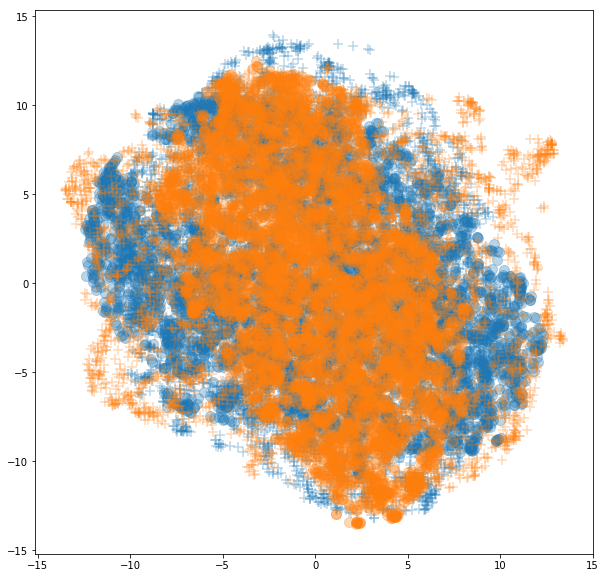

In [9]:
primary_train_embeddings, primary_train_labels = extract_embeddings(primay_train_loader, model, domain='primary')
helper_train_embeddings, helper_train_labels = extract_embeddings(helper_train_loader, model, domain='helper')


plot_embeddings(primary_train_embeddings, primary_train_labels, helper_train_embeddings, helper_train_labels)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 980 samples in 0.002s...
[t-SNE] Computed neighbors for 980 samples in 0.139s...
[t-SNE] Computed conditional probabilities for sample 980 / 980
[t-SNE] Mean sigma: 0.351824
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.684456
[t-SNE] Error after 300 iterations: 1.228657
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1744 samples in 0.003s...
[t-SNE] Computed neighbors for 1744 samples in 0.342s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1744
[t-SNE] Computed conditional probabilities for sample 1744 / 1744
[t-SNE] Mean sigma: 0.186182
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.028374
[t-SNE] Error after 300 iterations: 1.506562
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1135 samples in 0.002s...
[t-SNE] Computed neighbors for 1135 samples in 0.194s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1135
[t-SNE] Co

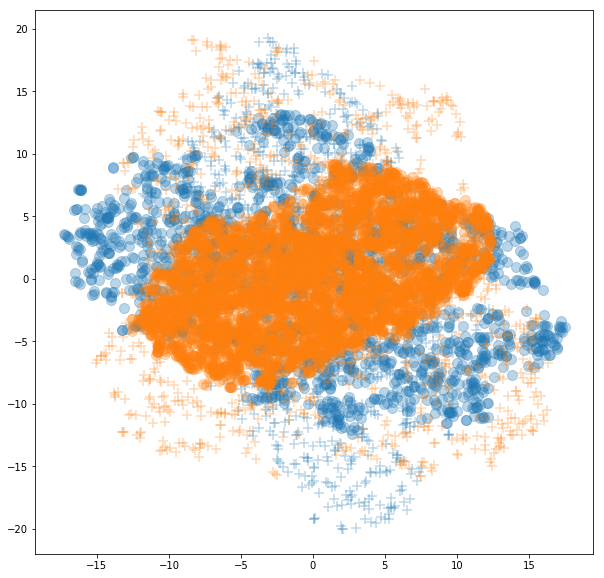

In [10]:
primary_test_embeddings, primary_test_labels = extract_embeddings(primay_test_loader, model, domain='primary')
helper_test_embeddings, helper_test_labels = extract_embeddings(helper_test_loader, model, domain='helper')


plot_embeddings(primary_test_embeddings, primary_test_labels, helper_test_embeddings, helper_test_labels)

Loss function when 2-dimensional embedding is used

Train: [0/50000 (0%)]	Loss: 0.990621
Train: [12800/50000 (26%)]	Loss: 0.999934
Train: [25600/50000 (51%)]	Loss: 0.960436
Train: [38400/50000 (77%)]	Loss: 0.577629
Epoch: 1/20. Train set: Average loss: 0.7243
Epoch: 1/20. Validation set: Average loss: 0.2870
Train: [0/50000 (0%)]	Loss: 0.211903
Train: [12800/50000 (26%)]	Loss: 0.226859
Train: [25600/50000 (51%)]	Loss: 0.181758
Train: [38400/50000 (77%)]	Loss: 0.156189
Epoch: 2/20. Train set: Average loss: 0.1776
Epoch: 2/20. Validation set: Average loss: 0.1338
Train: [0/50000 (0%)]	Loss: 0.175529
Train: [12800/50000 (26%)]	Loss: 0.121179
Train: [25600/50000 (51%)]	Loss: 0.116690
Train: [38400/50000 (77%)]	Loss: 0.106721
Epoch: 3/20. Train set: Average loss: 0.1108
Epoch: 3/20. Validation set: Average loss: 0.1173
Train: [0/50000 (0%)]	Loss: 0.110023
Train: [12800/50000 (26%)]	Loss: 0.097513
Train: [25600/50000 (51%)]	Loss: 0.087354
Train: [38400/50000 (77%)]	Loss: 0.090835
Epoch: 4/20. Train set: Average loss: 0.0900
Epoch: 4/20. Valid

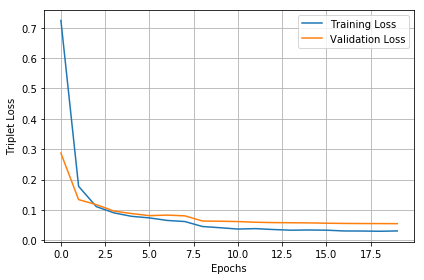

In [9]:
lossDict = fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
showLossHist(lossDict)

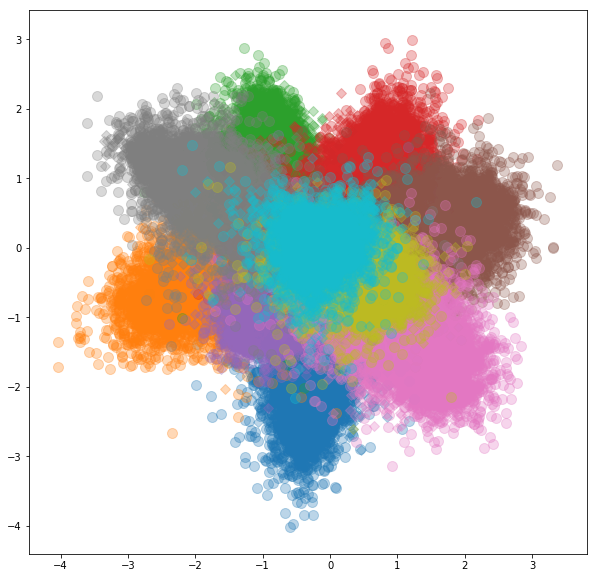

In [14]:
primary_train_embeddings, primary_train_labels = extract_embeddings(primay_train_loader, model, domain='primary')
helper_train_embeddings, helper_train_labels = extract_embeddings(helper_train_loader, model, domain='helper')


plot_embeddings(primary_train_embeddings, primary_train_labels, helper_train_embeddings, helper_train_labels)

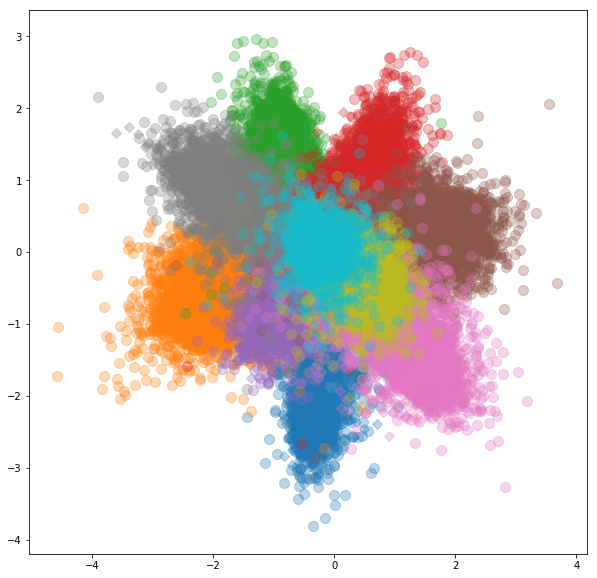

In [15]:
primary_test_embeddings, primary_test_labels = extract_embeddings(primay_test_loader, model, domain='primary')
helper_test_embeddings, helper_test_labels = extract_embeddings(helper_test_loader, model, domain='helper')


plot_embeddings(primary_test_embeddings, primary_test_labels, helper_test_embeddings, helper_test_labels)

### Conducting the same experiments for 'USPS'

In [10]:
primaryDataset = 'MNIST'
helperDataset = 'USPS'

# raw test data, seperate for both the primary and helper class
train_dataset_primary = loadDataset(primaryDataset, classes, instances,'train')
train_dataset_helper = loadDataset(helperDataset, classes, instances, 'train' )

# raw test data, seperate for both the primary and helper class
test_dataset_primary = loadDataset(primaryDataset, classes, instances,'test')
test_dataset_helper = loadDataset(helperDataset, classes, instances, 'test' )


primay_train_loader = torch.utils.data.DataLoader(train_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_train_loader = torch.utils.data.DataLoader(train_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primay_test_loader = torch.utils.data.DataLoader(test_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_test_loader = torch.utils.data.DataLoader(test_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

triplet_train_dataset=TripletCD(train_dataset_primary, train_dataset_helper)
triplet_test_dataset=TripletCD(test_dataset_primary, test_dataset_helper)


triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [11]:
margin = 1.
embedding_net_primary = LeNet(getChannels(primaryDataset))
embedding_net_helper = LeNet(getChannels(helperDataset))

model = TripletNet(embedding_net_primary, embedding_net_helper)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

modelFolderName = 'models'

Train: [0/50000 (0%)]	Loss: 1.007734
Train: [12800/50000 (26%)]	Loss: 0.356599
Train: [25600/50000 (51%)]	Loss: 0.117037
Train: [38400/50000 (77%)]	Loss: 0.073857
Epoch: 1/20. Train set: Average loss: 0.1572
Epoch: 1/20. Validation set: Average loss: 0.0513
Train: [0/50000 (0%)]	Loss: 0.057539
Train: [12800/50000 (26%)]	Loss: 0.043760
Train: [25600/50000 (51%)]	Loss: 0.041986
Train: [38400/50000 (77%)]	Loss: 0.032215
Epoch: 2/20. Train set: Average loss: 0.0383
Epoch: 2/20. Validation set: Average loss: 0.0390
Train: [0/50000 (0%)]	Loss: 0.021303
Train: [12800/50000 (26%)]	Loss: 0.034478
Train: [25600/50000 (51%)]	Loss: 0.028675
Train: [38400/50000 (77%)]	Loss: 0.020789
Epoch: 3/20. Train set: Average loss: 0.0263
Epoch: 3/20. Validation set: Average loss: 0.0182
Train: [0/50000 (0%)]	Loss: 0.050422
Train: [12800/50000 (26%)]	Loss: 0.020864
Train: [25600/50000 (51%)]	Loss: 0.023139
Train: [38400/50000 (77%)]	Loss: 0.021641
Epoch: 4/20. Train set: Average loss: 0.0212
Epoch: 4/20. Valid

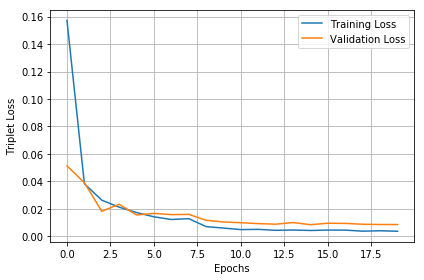

In [12]:
lossDict = fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
showLossHist(lossDict)

checkAndCreateFolder(modelFolderName)
modelFileName = primaryDataset + '_' + helperDataset + '_' + 'triplet' + '.pt'
PATH = modelFolderName + '/' + modelFileName
torch.save(model.state_dict(), PATH)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.009s...
[t-SNE] Computed neighbors for 5000 samples in 3.246s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.359700
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.442848
[t-SNE] Error after 300 iterations: 2.346384
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 767 samples in 0.001s...
[t-SNE] Computed neighbors for 767 samples in 0.122s...
[t-SNE] Computed conditional probabilities for sample 767 / 767
[t-SNE] Mean sigma: 0.136096
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.431870
[t-SNE] Error after 300 iterations: 0.937806
[t-SNE] Computing 12

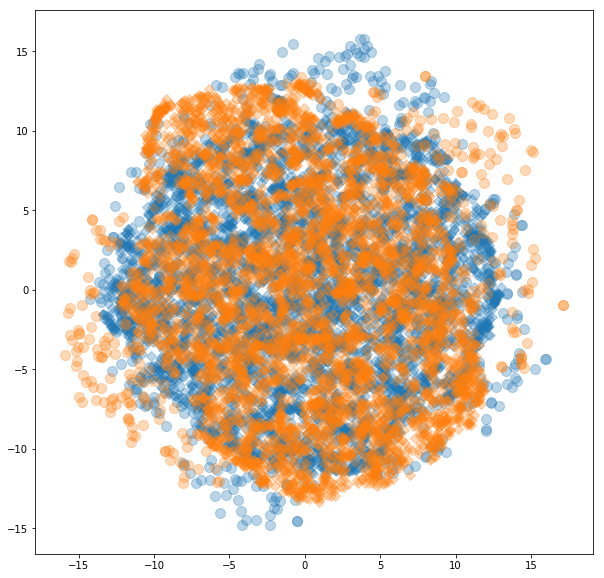

In [9]:
primary_train_embeddings, primary_train_labels = extract_embeddings(primay_train_loader, model, domain='primary')
helper_train_embeddings, helper_train_labels = extract_embeddings(helper_train_loader, model, domain='helper')


plot_embeddings(primary_train_embeddings, primary_train_labels, helper_train_embeddings, helper_train_labels)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 980 samples in 0.002s...
[t-SNE] Computed neighbors for 980 samples in 0.235s...
[t-SNE] Computed conditional probabilities for sample 980 / 980
[t-SNE] Mean sigma: 0.488482
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.414574
[t-SNE] Error after 300 iterations: 1.347904
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 786 samples in 0.001s...
[t-SNE] Computed neighbors for 786 samples in 0.166s...
[t-SNE] Computed conditional probabilities for sample 786 / 786
[t-SNE] Mean sigma: 0.136849
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.631649
[t-SNE] Error after 300 iterations: 0.967233
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1135 samples in 0.002s...
[t-SNE] Computed neighbors for 1135 samples in 0.305s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1135
[t-SNE] Computed conditional probabilities for sample 1135 / 1135
[t-SNE] Mean s

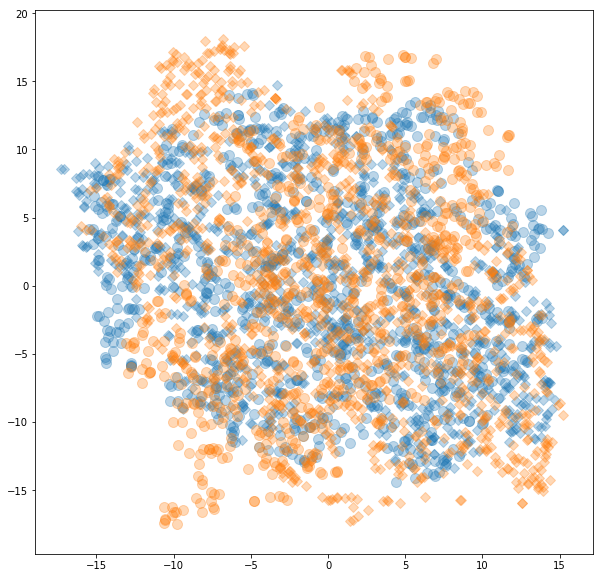

In [10]:
primary_test_embeddings, primary_test_labels = extract_embeddings(primay_test_loader, model, domain='primary')
helper_test_embeddings, helper_test_labels = extract_embeddings(helper_test_loader, model, domain='helper')


plot_embeddings(primary_test_embeddings, primary_test_labels, helper_test_embeddings, helper_test_labels)

Loss function when 2-dimensional embedding is used

Train: [0/50000 (0%)]	Loss: 0.999605
Train: [12800/50000 (26%)]	Loss: 0.474330
Train: [25600/50000 (51%)]	Loss: 0.290719
Train: [38400/50000 (77%)]	Loss: 0.209998
Epoch: 1/20. Train set: Average loss: 0.2927
Epoch: 1/20. Validation set: Average loss: 0.1545
Train: [0/50000 (0%)]	Loss: 0.127584
Train: [12800/50000 (26%)]	Loss: 0.143639
Train: [25600/50000 (51%)]	Loss: 0.132689
Train: [38400/50000 (77%)]	Loss: 0.124661
Epoch: 2/20. Train set: Average loss: 0.1301
Epoch: 2/20. Validation set: Average loss: 0.1242
Train: [0/50000 (0%)]	Loss: 0.156455
Train: [12800/50000 (26%)]	Loss: 0.102834
Train: [25600/50000 (51%)]	Loss: 0.094030
Train: [38400/50000 (77%)]	Loss: 0.097731
Epoch: 3/20. Train set: Average loss: 0.0945
Epoch: 3/20. Validation set: Average loss: 0.0936
Train: [0/50000 (0%)]	Loss: 0.137078
Train: [12800/50000 (26%)]	Loss: 0.082327
Train: [25600/50000 (51%)]	Loss: 0.075172
Train: [38400/50000 (77%)]	Loss: 0.069282
Epoch: 4/20. Train set: Average loss: 0.0753
Epoch: 4/20. Valid

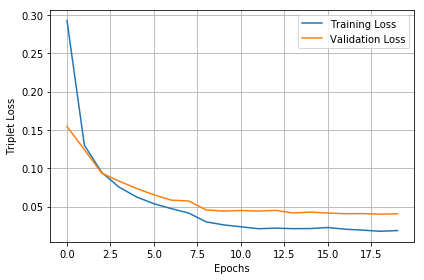

In [18]:
lossDict = fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
showLossHist(lossDict)

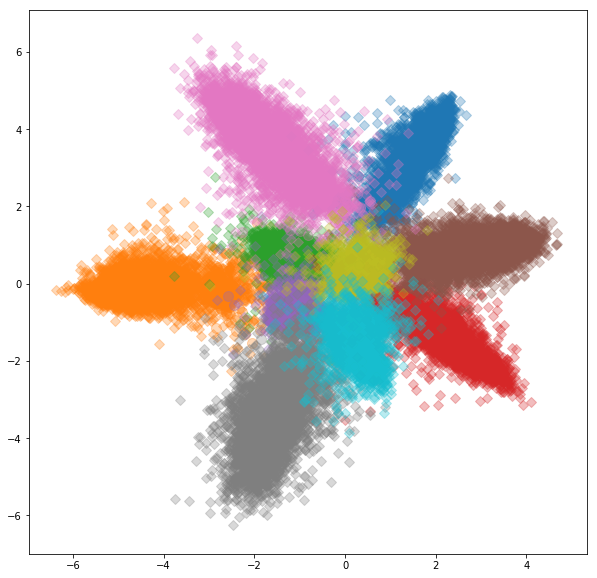

In [19]:
primary_train_embeddings, primary_train_labels = extract_embeddings(primay_train_loader, model, domain='primary')
helper_train_embeddings, helper_train_labels = extract_embeddings(helper_train_loader, model, domain='helper')


plot_embeddings(primary_train_embeddings, primary_train_labels, helper_train_embeddings, helper_train_labels)

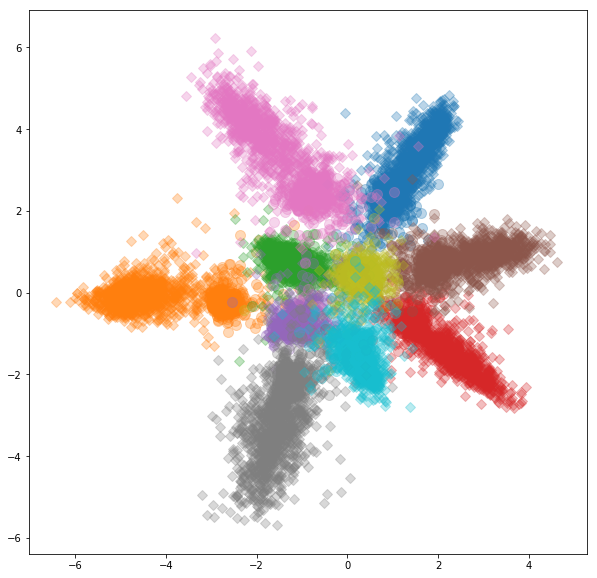

In [20]:
primary_test_embeddings, primary_test_labels = extract_embeddings(primay_test_loader, model, domain='primary')
helper_test_embeddings, helper_test_labels = extract_embeddings(helper_test_loader, model, domain='helper')


plot_embeddings(primary_test_embeddings, primary_test_labels, helper_test_embeddings, helper_test_labels)